# Hardbrücke 

## Quelle

https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [12]:
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics 

## Get Data

In [43]:
import lightgbm as lgb

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os

In [ ]:
os.listdir('/content/gdrive/MyDrive/ColabNotebooks/hardbruecke')

In [5]:
filepath = '/content/gdrive/MyDrive/ColabNotebooks/hardbruecke/frequenzen_hardbruecke_2020.zip'

In [6]:
hb = pd.read_csv(filepath,compression='zip')

In [7]:
hb['Timestamp'] = pd.to_datetime(hb['Timestamp'])

In [8]:
hb.head()

,In,Out,Timestamp,Name
0,1,0,2020-01-01 23:55:00,Ost-Nord total
1,2,5,2020-01-01 23:50:00,Ost-Nord total
2,1,0,2020-01-01 23:45:00,Ost-Nord total
3,1,4,2020-01-01 23:40:00,Ost-Nord total
4,1,0,2020-01-01 23:35:00,Ost-Nord total


In [9]:
hb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714681 entries, 0 to 714680
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   In         714681 non-null  int64         
 1   Out        714681 non-null  int64         
 2   Timestamp  714681 non-null  datetime64[ns]
 3   Name       714681 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 21.8+ MB


In [10]:
hb.describe()

,In,Out
count,714681.000000,714681.000000
mean,12.405247,10.299464
std,16.061613,12.936968
min,0.000000,0.000000
25%,3.000000,2.000000
50%,7.000000,6.000000
75%,16.000000,13.000000
max,253.000000,276.000000


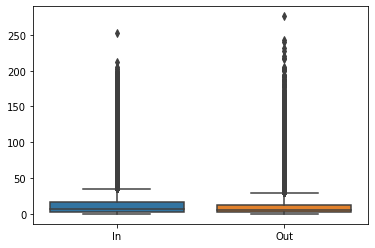

In [11]:
sns.boxplot(data=hb[['In','Out']])

In [12]:
hb2 = hb.set_index(['Timestamp','Name']).stack().reset_index()

In [13]:
hb2.head()

,Timestamp,Name,level_2,0
0,2020-01-01 23:55:00,Ost-Nord total,In,1
1,2020-01-01 23:55:00,Ost-Nord total,Out,0
2,2020-01-01 23:50:00,Ost-Nord total,In,2
3,2020-01-01 23:50:00,Ost-Nord total,Out,5
4,2020-01-01 23:45:00,Ost-Nord total,In,1


## Data preparation

In [14]:
hb2 = hb2.rename(columns={'level_2':'direction',0:'count'})

In [15]:
hb2.head()

,Timestamp,Name,direction,count
0,2020-01-01 23:55:00,Ost-Nord total,In,1
1,2020-01-01 23:55:00,Ost-Nord total,Out,0
2,2020-01-01 23:50:00,Ost-Nord total,In,2
3,2020-01-01 23:50:00,Ost-Nord total,Out,5
4,2020-01-01 23:45:00,Ost-Nord total,In,1


In [16]:
hb2['hour'] = hb2['Timestamp'].dt.hour
hb2['weekday'] = hb2['Timestamp'].dt.weekday
hb2['minute'] = hb2['Timestamp'].dt.minute
hb2['month'] = hb2['Timestamp'].dt.month

In [17]:
hb2['direction_cat'] = hb2['direction'].replace({'In':0,'Out':1})

In [18]:
names = {
    'Ost-Süd total' : 0,
    'Ost-Nord total' : 1,
    'Ost-SBB total' : 2,
    'West-SBB total' : 3,
    'West-Süd total' : 4,
    'Ost-VBZ Total' : 5,
    'West-Nord total' : 6,
    'West-VBZ total' : 7,
}
hb2['name_cat'] = hb2['Name'].replace(names)

In [19]:
hb2

,Timestamp,Name,direction,count,hour,weekday,minute,month,direction_cat,name_cat
0,2020-01-01 23:55:00,Ost-Nord total,In,1,23,2,55,1,0,1
1,2020-01-01 23:55:00,Ost-Nord total,Out,0,23,2,55,1,1,1
2,2020-01-01 23:50:00,Ost-Nord total,In,2,23,2,50,1,0,1
3,2020-01-01 23:50:00,Ost-Nord total,Out,5,23,2,50,1,1,1
4,2020-01-01 23:45:00,Ost-Nord total,In,1,23,2,45,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1429357,2020-12-31 00:15:00,West-VBZ total,Out,4,0,3,15,12,1,7
1429358,2020-12-31 00:10:00,West-VBZ total,In,3,0,3,10,12,0,7
1429359,2020-12-31 00:10:00,West-VBZ total,Out,5,0,3,10,12,1,7
1429360,2020-12-31 00:05:00,West-VBZ total,In,4,0,3,5,12,0,7


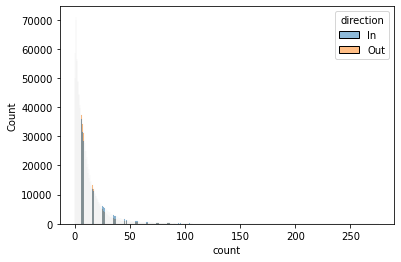

In [20]:
sns.histplot(data=hb2,x='count',hue='direction')

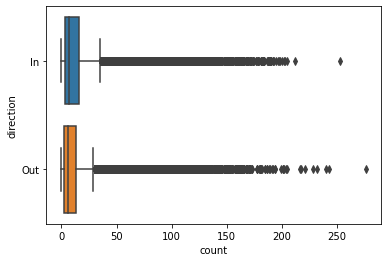

In [21]:
sns.boxplot(data=hb2,x='count',y='direction')

In [22]:
hb2['Name'].value_counts()

Ost-Süd total      188858
Ost-Nord total     184822
Ost-SBB total      181088
West-SBB total     180502
West-Süd total     178876
Ost-VBZ Total      174570
West-Nord total    171872
West-VBZ total     168774
Name: Name, dtype: int64

In [23]:
hb2['direction'].value_counts()

Out    714681
In     714681
Name: direction, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

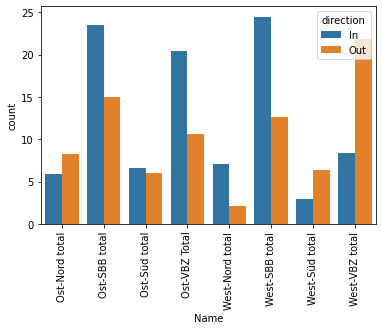

In [24]:
name = hb2.groupby(['Name','direction'])['count'].mean()
sns.barplot(data=name.reset_index(),x='Name',y='count',hue='direction')
plt.xticks(rotation = 90)

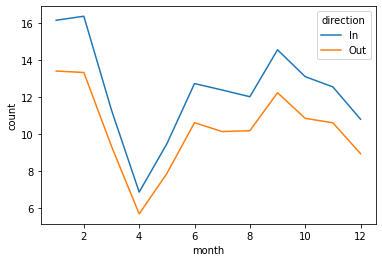

In [25]:
months = hb2.groupby(['month','direction'])['count'].mean()
sns.lineplot(data=months.reset_index(),x='month',y='count',hue='direction')

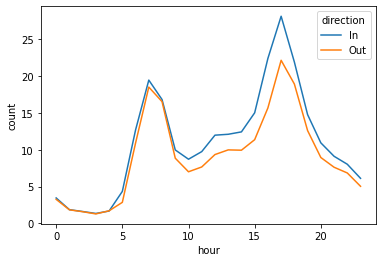

In [26]:
hour = hb2.groupby(['hour','direction'])['count'].mean()
sns.lineplot(data=hour.reset_index(),x='hour',y='count',hue='direction')

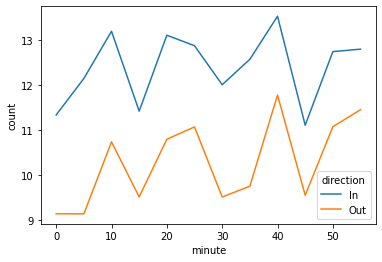

In [27]:
minute = hb2.groupby(['minute','direction'])['count'].mean()
sns.lineplot(data=minute.reset_index(),x='minute',y='count',hue='direction')

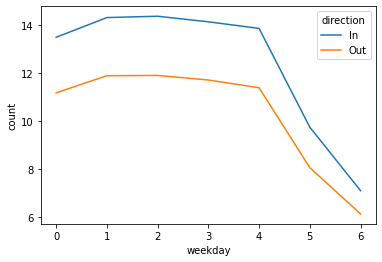

In [28]:
weekday = hb2.groupby(['weekday','direction'])['count'].mean()
sns.lineplot(data=weekday.reset_index(),x='weekday',y='count',hue='direction')

In [29]:
hb2.head()

,Timestamp,Name,direction,count,hour,weekday,minute,month,direction_cat,name_cat
0,2020-01-01 23:55:00,Ost-Nord total,In,1,23,2,55,1,0,1
1,2020-01-01 23:55:00,Ost-Nord total,Out,0,23,2,55,1,1,1
2,2020-01-01 23:50:00,Ost-Nord total,In,2,23,2,50,1,0,1
3,2020-01-01 23:50:00,Ost-Nord total,Out,5,23,2,50,1,1,1
4,2020-01-01 23:45:00,Ost-Nord total,In,1,23,2,45,1,0,1


# Machine Learning

In [31]:
hb2.head()

,Timestamp,Name,direction,count,hour,weekday,minute,month,direction_cat,name_cat
0,2020-01-01 23:55:00,Ost-Nord total,In,1,23,2,55,1,0,1
1,2020-01-01 23:55:00,Ost-Nord total,Out,0,23,2,55,1,1,1
2,2020-01-01 23:50:00,Ost-Nord total,In,2,23,2,50,1,0,1
3,2020-01-01 23:50:00,Ost-Nord total,Out,5,23,2,50,1,1,1
4,2020-01-01 23:45:00,Ost-Nord total,In,1,23,2,45,1,0,1


In [32]:
#hb2.groupby(['hour'])['count'].sum()

In [33]:
XList=[
  'hour',
  'weekday',
  'minute',
  'month',
  'direction_cat',
  'name_cat',
]
y='count'

In [34]:
if True:
  hb2X=hb2[XList]
  hb2Y=hb2[y]
  X_train, X_test, y_train, y_test = train_test_split(hb2X, hb2Y)  

## Decicion Tree

In [35]:
regressor = DecisionTreeRegressor(max_depth=15)  
regressor.fit(X_train, y_train)  

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [36]:
import pickle

In [37]:
filename = '/content/gdrive/MyDrive/ColabNotebooks/hardbruecke/models/DecisionTreeRegressor.sav'
#pickle.dump(regressor, open(filename, 'wb'))

In [38]:
#regressor = pickle.load(open(filename, 'rb'))

Die anderen Modelle performen fast identisch. Einfache Transformationen haben nichts gebracht. Die Performance ist nicht optimal aber für einen ersten Test gut genug.

Möglicherweise würden einige Zusatzinformationen noch etwas bringen. Z.B. Lockdown relevante Informationen, oder ein Feiertagskalender. Auch die Pünktlichkeitsdaten (bzw. der Fahrplan) könnten helfen.
-> Komplexität der Implementierung sollte geprüft werden

In [39]:
y_pred = regressor.predict(X_test) 

In [40]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})  
df.head(20)

,Actual,Predicted
827928,4,10.759682
1091504,6,3.330769
69088,5,2.444444
1050366,70,58.650295
263003,6,7.769231
236147,2,6.682927
58697,8,6.714286
505317,2,1.414179
909199,29,18.812500
413526,1,0.869159


In [41]:
importance = regressor.feature_importances_
importance_df = pd.DataFrame(importance, index=X_train.columns, 
                      columns=["Importance"])
importance_df

,Importance
hour,0.369299
weekday,0.094345
minute,0.043425
month,0.121135
direction_cat,0.111558
name_cat,0.260238


In [42]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 4.434770702287372
Mean Squared Error: 58.19054249137936
Root Mean Squared Error: 7.628272575844374


(0.0, 253.0, -10.0, 210.0)

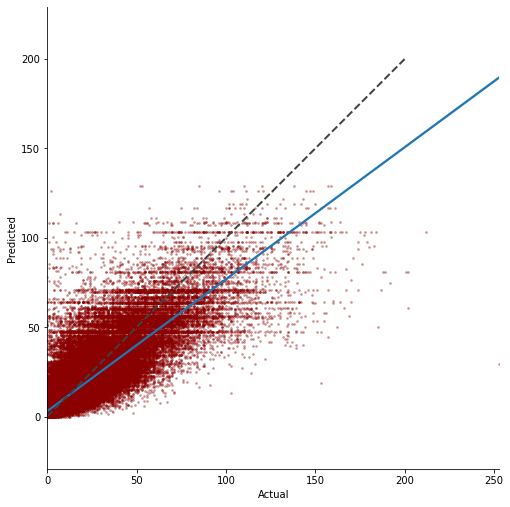

In [43]:
# vorsicht: es wird nur ein Ausschnitt der Daten angezeigt
sns.lmplot(x='Actual', y='Predicted', data=df,fit_reg=True,scatter_kws={"color":"darkred","alpha":0.3,"s":3},height=7)
# add y=x line
plt.plot([0,200],[0,200], lw=2, color='#414242', linestyle='dashed') # ideallinie wo predicted = actual
plt.axis('equal')


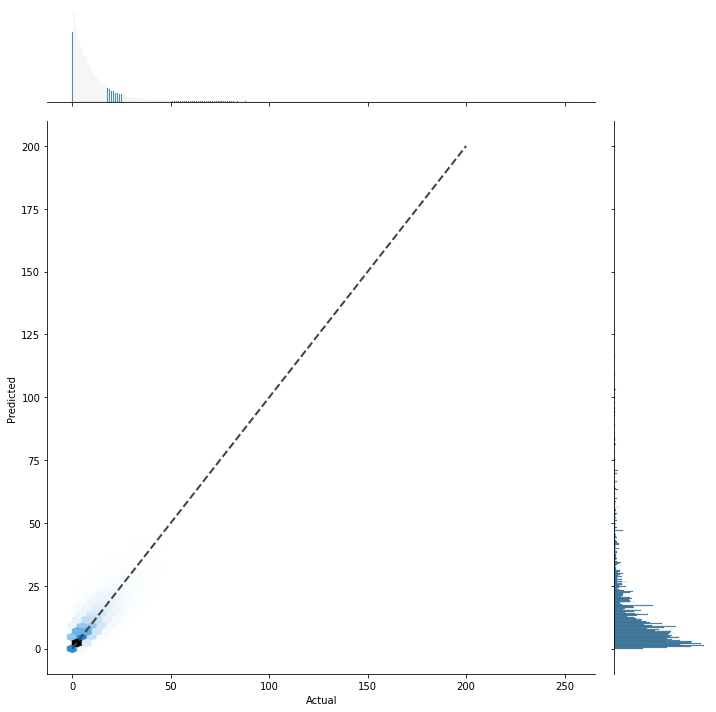

In [44]:
sns.jointplot(x='Actual', y='Predicted', data=df,kind='hex',height=10)
# add y=x line
plt.plot([0,200],[0,200], lw=2, color='#414242', linestyle='dashed') # ideallinie wo predicted = actual
#plt.axis('equal')
#plt.xlim((0,50))
#plt.ylim((0,50))

## Radom Forest

In [70]:
regressor = RandomForestRegressor(n_estimators=100,n_jobs=-1,max_depth=20) 
regressor.fit(X_train, y_train)  

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [71]:
y_pred = regressor.predict(X_test) 

In [72]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)


Mean Absolute Error: 4.404026170512739
Mean Squared Error: 58.05114972594296
Root Mean Squared Error: 7.619130509837915


(0.0, 253.0, -10.0, 210.0)

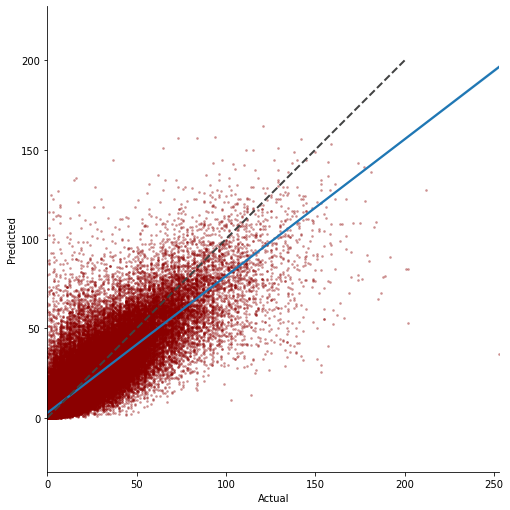

In [73]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred}) 
# vorsicht: es wird nur ein Ausschnitt der Daten angezeigt
sns.lmplot(x='Actual', y='Predicted', data=df,fit_reg=True,scatter_kws={"color":"darkred","alpha":0.3,"s":3},height=7)
# add y=x line
plt.plot([0,200],[0,200], lw=2, color='#414242', linestyle='dashed') # ideallinie wo predicted = actual
plt.axis('equal')

In [68]:
filename = '/content/gdrive/MyDrive/ColabNotebooks/hardbruecke/models/RandomForestRegressor.sav'
#pickle.dump(regressor, open(filename, 'wb'))

## Linear Regression

In [49]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)  

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
y_pred = regressor.predict(X_test) 

In [51]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 9.228223859153097
Mean Squared Error: 205.6872385834668
Root Mean Squared Error: 14.341800395468722


(0.0, 253.0, -10.0, 210.0)

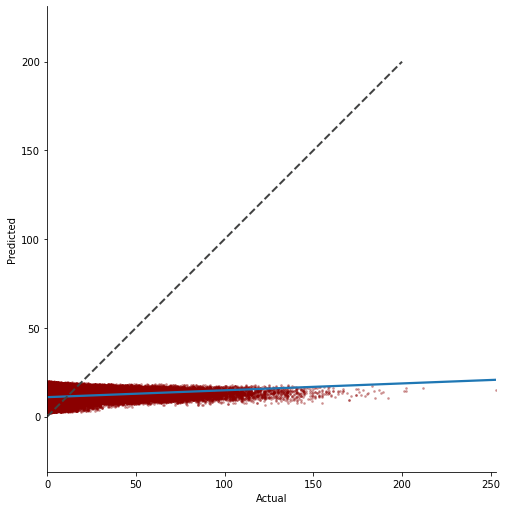

In [52]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred}) 
# vorsicht: es wird nur ein Ausschnitt der Daten angezeigt
sns.lmplot(x='Actual', y='Predicted', data=df,fit_reg=True,scatter_kws={"color":"darkred","alpha":0.3,"s":3},height=7)
# add y=x line
plt.plot([0,200],[0,200], lw=2, color='#414242', linestyle='dashed') # ideallinie wo predicted = actual
plt.axis('equal')

## lightgbm

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:
- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel and GPU learning.
- Capable of handling large-scale data.

https://lightgbm.readthedocs.io/en/latest/

Ausserdem können hier kategoriale Variablen explizit berücksichtigt werden.

In [54]:
# kategorielle Variablen
categorical_features = ['direction_cat','name_cat','weekday']
# alle Variablen
XList=[
  'hour',
  'weekday',
  'minute',
  'month',
  'direction_cat',
  'name_cat',
]
y='count'

#### Training

In [55]:
lgb_train = lgb.Dataset(X_train, y_train
 ,feature_name = XList
 , categorical_feature = categorical_features
)

In [56]:
params = {
 'task': 'train' 
 #, 'boosting_type': 'dart'
 #, 'max_depth' : 25
 , 'objective': 'regression' 
 #, 'num_leaves':60
 #, 'num_class': num_of_classes
 , 'metric': 'mse' #'mae' #'rmsle' 
 #,'min_data_in_leaf': 40
 #,'num_trees':100 # default 100
 #, 'min_data': 5
 #, 'verbose': -1
}
gbm = lgb.train(params, lgb_train)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.



#### Prognose

In [57]:
y_pred = gbm.predict(X_test)

In [58]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})  
df.tail()

,Actual,Predicted
444125,1,5.761507
879207,1,3.188945
150619,11,5.455683
1358878,0,2.833803
832535,2,4.138504


#### Validierung

(0.0, 253.0, -14.132334193304738, 210.1967778187288)

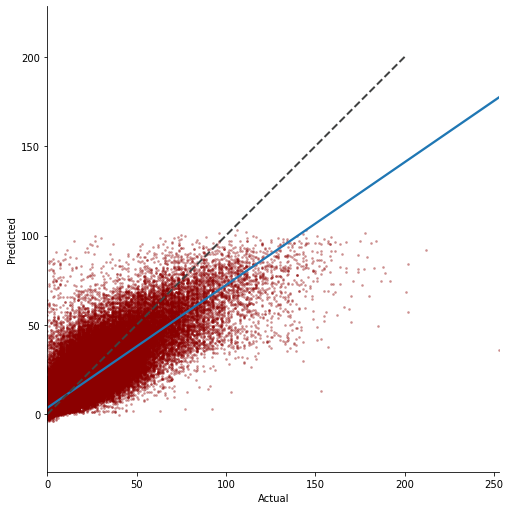

In [59]:
# vorsicht: es wird nur ein Ausschnitt der Daten angezeigt
sns.lmplot(x='Actual', y='Predicted', data=df,fit_reg=True,scatter_kws={"color":"darkred","alpha":0.3,"s":3},height=7)
# add y=x line
plt.plot([0,200],[0,200], lw=2, color='#414242', linestyle='dashed') # ideallinie wo predicted = actual
plt.axis('equal')


In [60]:
#sns.jointplot(x='Actual', y='Predicted', kind="reg", data=df)

In [61]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred) )
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score: ',metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 4.647723629649892
Mean Squared Error: 59.92956004837969
Root Mean Squared Error: 7.741418477797185
R2 Score:  0.7199101359716638


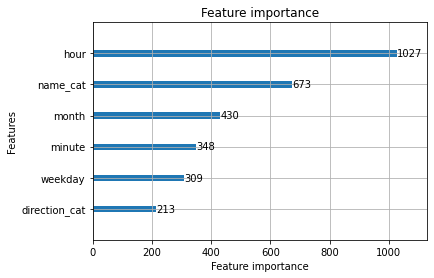

In [62]:
ax = lgb.plot_importance(gbm,)
plt.show()

# 2020+2021

In [22]:
def data_preparation(df, names):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index(['Timestamp', 'Name']).stack().reset_index()
    df = df.rename(columns={'level_2': 'direction', 0: 'count'})
    df['direction'] = df['direction'].astype('category')

    df['year'] = df['Timestamp'].dt.year

    df['hour'] = df['Timestamp'].dt.hour

    df['weekday'] = df['Timestamp'].dt.weekday

    df['minute'] = df['Timestamp'].dt.minute

    df['month'] = df['Timestamp'].dt.month

    df['day'] = pd.to_datetime(df['Timestamp'].dt.date)

    df['direction_cat'] = df['direction'].replace({'In': 0, 'Out': 1})

    df['name_cat'] = df['Name'].replace(names)

    return df

In [6]:
# parameters
names = {
    'Ost-Süd total': 0,
    'Ost-Sd total': 0,  # alias, as seen in api query
    'Ost-Nord total': 1,
    'Ost-SBB total': 2,
    'West-SBB total': 3,
    'West-Süd total': 4,
    'West-Sd total': 4,  # alias, as seen in api query
    'Ost-VBZ Total': 5,
    'West-Nord total': 6,
    'West-VBZ total': 7,
}

In [7]:
filepaths = [
             '/content/gdrive/MyDrive/ColabNotebooks/hardbruecke/frequenzen_hardbruecke_2020.zip',
             '/content/gdrive/MyDrive/ColabNotebooks/hardbruecke/frequenzen_hardbruecke_2021.zip'
]

In [8]:
hb = pd.DataFrame()
print("shape df: ", hb.shape)
for file in filepaths:
  print(file)
  hb = hb.append(pd.read_csv(file,compression='zip'))
  print("shape df: ", hb.shape)

shape df:  (0, 0)
/content/gdrive/MyDrive/ColabNotebooks/hardbruecke/frequenzen_hardbruecke_2020.zip
shape df:  (714681, 4)
/content/gdrive/MyDrive/ColabNotebooks/hardbruecke/frequenzen_hardbruecke_2021.zip
shape df:  (1170999, 4)


In [23]:
hb2 = data_preparation(hb, names)

In [24]:
XList=[
  'year',
  'hour',
  'weekday',
  'minute',
  'month',
  'direction_cat',
  'name_cat',
]
y='count'

In [25]:
if True:
  hb2X=hb2[XList]
  hb2Y=hb2[y]
  X_train, X_test, y_train, y_test = train_test_split(hb2X, hb2Y)  

In [15]:
def fit_and_evaluate(model, X_train, X_test, y_train, y_test):
  regressor = model
  regressor.fit(X_train, y_train)  
  y_pred = regressor.predict(X_test) 
  metric_df = pd.DataFrame(
    index=['Mean Absolute Error','Mean Squared Error','Root Mean Squared Error'],
    data={'value':[metrics.mean_absolute_error(y_test, y_pred),metrics.mean_squared_error(y_test, y_pred),np.sqrt(metrics.mean_squared_error(y_test, y_pred))]})
  return {
      'model': regressor,
      'y_pred': y_pred,
      'metrics': metric_df
  }

In [62]:
reg = fit_and_evaluate(RandomForestRegressor(n_estimators=3,n_jobs=-1,max_depth=20),
                      X_train, X_test, y_train, y_test)
reg['metrics']

,value
Mean Absolute Error,4.317813
Mean Squared Error,52.378234
Root Mean Squared Error,7.237281


In [63]:
models = {
          'DecisionTree': DecisionTreeRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=5), 
          'RandomForest': RandomForestRegressor(n_estimators=100,n_jobs=-1,max_depth=20) ,
          'GradientBoosting': GradientBoostingRegressor(),

}

In [64]:
output = {}
for m in models:
  print(m)
  output[m] = fit_and_evaluate(models[m], X_train, X_test, y_train, y_test)
  print(output[m]['metrics'])


DecisionTree
                             value
Mean Absolute Error       4.297283
Mean Squared Error       52.267675
Root Mean Squared Error   7.229639
RandomForest
                             value
Mean Absolute Error       4.187369
Mean Squared Error       49.176226
Root Mean Squared Error   7.012576
GradientBoosting
                             value
Mean Absolute Error       5.816674
Mean Squared Error       91.046163
Root Mean Squared Error   9.541811


Random Forest schneidet am besten ab, produziert aber ein riesiges Modell. Decision Tree ist nicht viel schlechter, aber einiges kleiner. Gradient Boosting scheint sich nicht zu lohnen (gilt auch für LightGBM)

(0.0, 217.0, -10.0, 210.0)

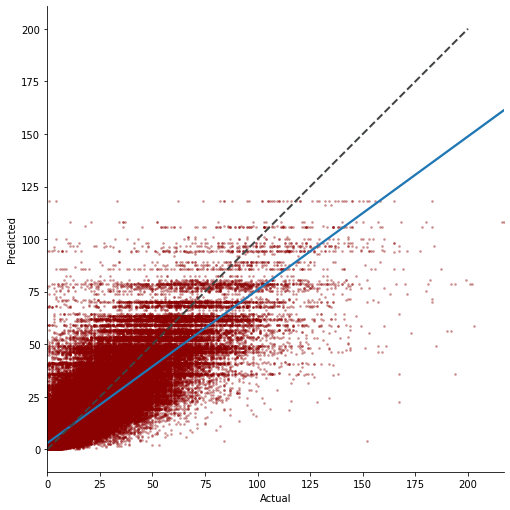

In [65]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':output['DecisionTree']['y_pred']}) 
# vorsicht: es wird nur ein Ausschnitt der Daten angezeigt
sns.lmplot(x='Actual', y='Predicted', data=df,fit_reg=True,
           scatter_kws={"color":"darkred","alpha":0.3,"s":3},height=7)
# add y=x line
plt.plot([0,200],[0,200], lw=2, color='#414242', linestyle='dashed') # ideallinie wo predicted = actual
plt.axis('equal')

(0.0, 30.0)

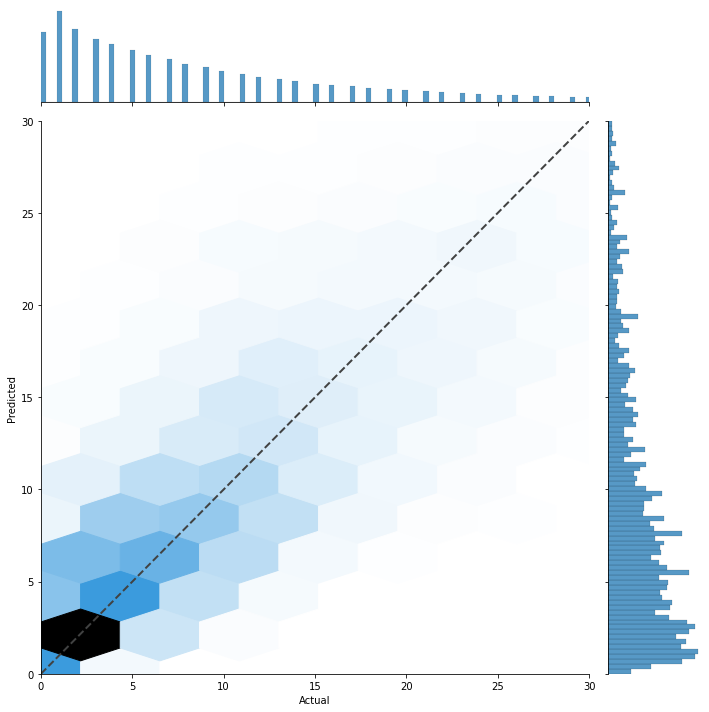

In [73]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':output['DecisionTree']['y_pred']}) 
sns.jointplot(x='Actual', y='Predicted', data=df,kind='hex',height=10)
# add y=x line
plt.plot([0,200],[0,200], lw=2, color='#414242', linestyle='dashed') # ideallinie wo predicted = actual
#plt.axis('equal')
plt.xlim((0,30))
plt.ylim((0,30))

## Cross Validation

In [30]:
from sklearn.model_selection import cross_val_score

In [57]:
scores = cross_val_score(DecisionTreeRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=5),
                         hb2[XList], hb2[y], cv=5,scoring = 'neg_mean_absolute_error')
print(scores)
print("neg_mean_absolute_error %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[-4.97022094 -5.25175311 -6.63354955 -5.26978659 -4.79113321]
neg_mean_absolute_error -5.38 with a standard deviation of 0.65


## Production Model

In [59]:
regressor = DecisionTreeRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=5)
regressor.fit(hb2[XList], hb2[y])

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [60]:
import pickle
filename = '/content/gdrive/MyDrive/ColabNotebooks/hardbruecke/models/2021_08_22_DecisionTreeRegressor.sav'
#pickle.dump(regressor, open(filename, 'wb'))

## lgbm

In [44]:
categorical_features = ['direction_cat','name_cat','weekday']

In [45]:
lgb_train = lgb.Dataset(X_train, y_train
 ,feature_name = XList
 , categorical_feature = categorical_features
)

In [46]:
params = {
 'task': 'train' 
 #, 'boosting_type': 'dart'
 #, 'max_depth' : 25
 , 'objective': 'regression' 
 #, 'num_leaves':60
 #, 'num_class': num_of_classes
 , 'metric': 'mse' #'mae' #'rmsle' 
 #,'min_data_in_leaf': 40
 #,'num_trees':100 # default 100
 #, 'min_data': 5
 #, 'verbose': -1
}
gbm = lgb.train(params, lgb_train)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.



In [47]:
y_pred = gbm.predict(X_test)

In [48]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred) )
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print('R2 Score: ',metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 4.468613984005747
Mean Squared Error: 53.24664160772796
Root Mean Squared Error: 7.297029642788082


# Log Transform

In [ ]:
hb2['count_log'] = np.log(hb2['count']+1)

In [ ]:
XList=[
  'hour',
  'weekday',
  'minute',
  'month',
  'direction_cat',
  'name_cat',
]
y='count_log'

In [ ]:
if True:
  hb2X=hb2[XList]
  hb2Y=hb2[y]
  X_train, X_test, y_train, y_test = train_test_split(hb2X, hb2Y)  

## Decicion Tree

In [ ]:
regressor = DecisionTreeRegressor(max_depth=15)  
regressor.fit(X_train, y_train)  

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_pred = regressor.predict(X_test) 

In [ ]:
df=pd.DataFrame({'Actual':np.exp(y_test)-1, 'Predicted':np.exp(y_pred)-1})  
df.head(20)

,Actual,Predicted
220845,13.0,10.478126
116990,2.0,3.278223
992814,25.0,24.705665
1062867,2.0,1.715174
1176740,1.0,0.404470
723486,17.0,22.010064
290480,35.0,27.617288
806006,10.0,7.813056
901952,28.0,41.610854
384508,19.0,11.701323


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 0.43173281651268436
Mean Squared Error: 0.3154181389753173
Root Mean Squared Error: 0.5616209922851151


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(np.exp(y_test)-1, np.exp(y_pred)-1))
print('Mean Squared Error:', metrics.mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 4.453969252728549
Mean Squared Error: 63.28957357746446
Root Mean Squared Error: 7.9554744407523845


## Radom Forest

In [ ]:
regressor = RandomForestRegressor(n_estimators=30,n_jobs=-1,max_depth=20) 
regressor.fit(X_train, y_train)  

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)


Mean Absolute Error: 0.43173281651268436
Mean Squared Error: 0.3154181389753173
Root Mean Squared Error: 0.5616209922851151


## Linear Regression

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)  

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 0.43173281651268436
Mean Squared Error: 0.3154181389753173
Root Mean Squared Error: 0.5616209922851151


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(np.exp(y_test)-1, np.exp(y_pred)-1))
print('Mean Squared Error:', metrics.mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 4.453969252728549
Mean Squared Error: 63.28957357746446
Root Mean Squared Error: 7.9554744407523845


# Try Dummies

In [ ]:
dummies = pd.get_dummies(hb2['Name'])
dummy_cols = dummies.columns

In [ ]:
hb2 = pd.concat([hb2,dummies],axis=1)
hb2.head()

,Timestamp,Name,direction,count,hour,weekday,minute,month,direction_cat,name_cat,count_log,Ost-Nord total,Ost-SBB total,Ost-Süd total,Ost-VBZ Total,West-Nord total,West-SBB total,West-Süd total,West-VBZ total
0,2020-01-01 23:55:00,Ost-Nord total,In,1,23,2,55,1,0,1,0.693147,1,0,0,0,0,0,0,0
1,2020-01-01 23:55:00,Ost-Nord total,Out,0,23,2,55,1,1,1,0.000000,1,0,0,0,0,0,0,0
2,2020-01-01 23:50:00,Ost-Nord total,In,2,23,2,50,1,0,1,1.098612,1,0,0,0,0,0,0,0
3,2020-01-01 23:50:00,Ost-Nord total,Out,5,23,2,50,1,1,1,1.791759,1,0,0,0,0,0,0,0
4,2020-01-01 23:45:00,Ost-Nord total,In,1,23,2,45,1,0,1,0.693147,1,0,0,0,0,0,0,0


In [ ]:
XList=[
  'hour',
  'weekday',
  'minute',
  'month',
  'direction_cat',
  #'name_cat',
] + dummy_cols.to_list()
y='count'

In [ ]:
if True:
  hb2X=hb2[XList]
  hb2Y=hb2[y]
  X_train, X_test, y_train, y_test = train_test_split(hb2X, hb2Y)  

## Decision Tree

In [ ]:
regressor = DecisionTreeRegressor(max_depth=15)  
regressor.fit(X_train, y_train)  

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_pred = regressor.predict(X_test) 

In [ ]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})  
df.head(20)

,Actual,Predicted
3242,16,12.859604
30709,20,14.608475
978722,33,26.896552
294199,7,7.666667
1286101,6,18.000000
765296,2,2.138047
48801,14,13.918539
657163,11,22.545455
537019,1,4.806841
379730,6,5.604502


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 4.506440658037878
Mean Squared Error: 58.11544660857731
Root Mean Squared Error: 7.623348779150624


## Radom Forest

In [ ]:
regressor = RandomForestRegressor(n_estimators=30,n_jobs=-1,max_depth=20) 
regressor.fit(X_train, y_train)  

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)


Mean Absolute Error: 4.506440658037878
Mean Squared Error: 58.11544660857731
Root Mean Squared Error: 7.623348779150624


## Linear Regression

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)  

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print 'R2 Score: ',metrics.r2_score(y_test, y_pred)

Mean Absolute Error: 4.506440658037878
Mean Squared Error: 58.11544660857731
Root Mean Squared Error: 7.623348779150624


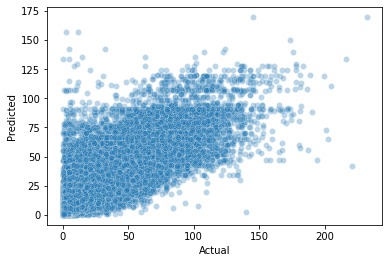

In [ ]:
sns.scatterplot(data=df,y='Predicted',x='Actual',alpha=0.3)